<h1 style="font-size:240%; color:blue; text-align:center; line-height:45px;"> 1. Filtro Mediana Adaptativo </h1>

<p style="font-size:135%;">En el siguiente código se ilustra la implementación del filtro por mediana adaptativo, probado para una imagen real a la cual se le agrega ruido Gaussiano:</p>

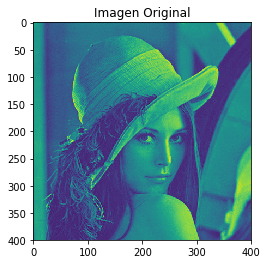

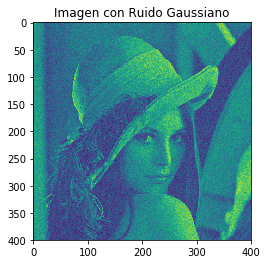

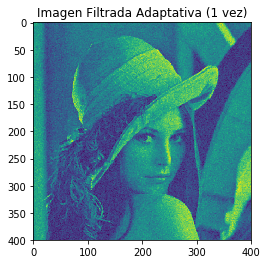

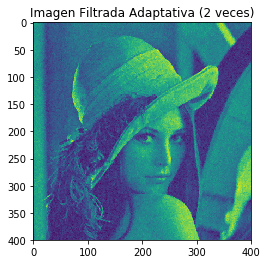

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import os
import math

#Additive noise Gaussian
#Reference: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def noisyGauss(image, mean, var):
    #row, col, ch = image.shape
    row, col = image.shape
    sigma = math.sqrt(var)
    #gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = np.random.normal(mean, sigma, (row, col))
    #gauss = gauss.reshape(row, col, ch)
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy

def noisySyP(image):
    row, col, ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    #Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords] = 1
    #Pepper mode
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords] = 0
    return out

def localWindow(image, x, y, lk):
    top = 0
    bottom = 0
    an = 0
    al = 0
    alto, ancho = image.shape
    if y - lk >= 0:
        top = y - lk
    else:
        top = 0
    if y + lk < alto:
        bottom = y + lk
    else:
        bottom = alto - 1
    if x - lk >= 0:
        left = x - lk
    else:
        left = 0
    if x + lk < ancho:
        right = x + lk
    else:
        right = ancho - 1
    an = right - left + 1
    al = bottom - top + 1
    return top, left, al, an

def medianAdaptive(image, smax):
    alto, ancho = image.shape
    imageRes = image.copy()
    for x in range(ancho):
        for y in range(alto):
            newColor = None
            for lk in range(1, smax + 1):
                tp, le, al, an = localWindow(image, x, y, lk)
                subImage = image[tp : tp + al, le : le + an]
                zmin = np.min(subImage)
                zmax = np.max(subImage)
                zmed = np.median(subImage)
                a1 = zmed - zmin
                a2 = zmed - zmax
                if a1 > 0 and a2 < 0:
                    b1 = image[y][x] - zmin
                    b2 = image[y][x] - zmax
                    if b1 > 0 and b2 < 0:
                        newColor = image[y][x]
                        imageRes[y][x] = newColor
                        break
                    else:
                        newColor = zmed
                        imageRes[y][x] = zmed
                        break
            if newColor == None:
                newColor = image[y][x]
                imageRes[y][x] = newColor
    return imageRes

imagen = cv2.imread('Figures/Lenna.jpg')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
mean = 35
var = 200
imagenGauss = noisyGauss(imagen, mean, var)
imR = medianAdaptive(imagenGauss, 5)
imR2 = medianAdaptive(imR, 5)

plt.figure(1000)
plt.subplot(111)
plt.imshow(imagen)
plt.title('Imagen Original')
plt.show()
plt.subplot(111)
plt.imshow(imagenGauss)
plt.title('Imagen con Ruido Gaussiano')
plt.show()
plt.subplot(111)
plt.imshow(imR)
plt.title('Imagen Filtrada Adaptativa (1 vez)')
plt.show()
plt.subplot(111)
plt.imshow(imR2)
plt.title('Imagen Filtrada Adaptativa (2 veces)')
plt.show()

<p style="font-size:135%;">A partir de la imagen original, se le agregó un ruido de tipo Gaussiano con media de 35 y varianza de 200 para obtener una imagen notablemente ruidosa, luego se le aplicó el filtro por mediana adaptativo con un radio de región máxima de 5 pixeles, y se puede observar que reduce un poco el ruido y a la vez se preservan detalles en contornos como se puede notar en el cabello, luego a la imagen obtenido se le volvió a aplicar el filtro implementado y se puede concluir que el filtro reduce el ruido poco a poco y a la vez preserva de la mejor forma posible detalles importantes de la imagen como los contornos. Con el ruido de tipo sal, se puede evidenciar un buen desempeño de este filtro que se puede aplicar sucesivas veces para una reducción mayor de ruido aunque con una ligera pérdida de detalles como en los contornos (Comparado con filtros como medianBlur, a pesar de reducir el ruido, solo se tiene una ligera y no considerable pérdida de detalles de las características de la imagen).</p>

<h1 style="font-size:240%; color:blue; text-align:center; line-height:45px;"> 3. Filtro de Wiener </h1>

<p style="font-size:135%;">En el siguiente código se ilustra una implementación del filtro de Wiener, probado para una imagen real a la cual se le agrega un efecto de degradación de tipo motion_blur, además de un ruido Gaussiano:</p>

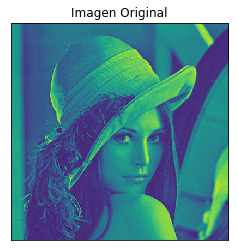

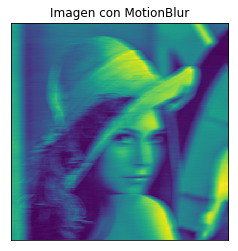

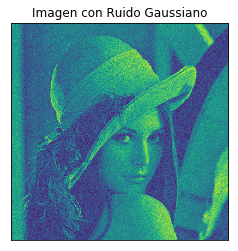

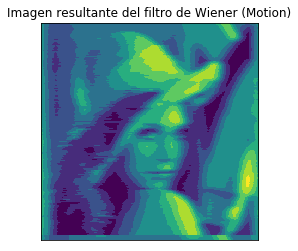

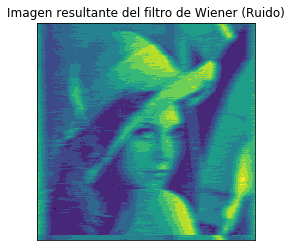

In [15]:
import cv2
import numpy as np

imagen = cv2.imread('Figures/Lenna.jpg')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
size = 20

#generating the kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur[int((size - 1) / 2), :] = np.ones(size)
kernel_motion_blur = kernel_motion_blur / size

#applying the kernel to the input image
output = cv2.filter2D(imagen, -1, kernel_motion_blur)

import matplotlib.pyplot as plt
import cv2
import numpy as np
from numpy.fft import fft2, ifft2

def wiener_filter(img, kernel, K = 10):
    dummy = np.copy(img)
    kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return np.uint8(dummy)

i = wiener_filter(output, kernel_motion_blur, size)
output2 = noisyGauss(imagen, 35, 200)
i2 = wiener_filter(output2, kernel_motion_blur, size)

plt.figure(1001)
plt.subplot(111), plt.imshow(imagen)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(output)
plt.title('Imagen con MotionBlur'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(output2)
plt.title('Imagen con Ruido Gaussiano'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(i)
plt.title('Imagen resultante del filtro de Wiener (Motion)'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(111), plt.imshow(i2)
plt.title('Imagen resultante del filtro de Wiener (Ruido)'), plt.xticks([]), plt.yticks([])
plt.show()